# Fuzzy system setup
Load the processed data and define membership functions for the variables.

In [4]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix,
    brier_score_loss
)

Matplotlib created a temporary cache directory at /tmp/matplotlib-m_z4lrac because the default path (/home/mauro/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
df = pd.read_csv("data_processed.csv")
df.head()

,driver,maneuver,window_start,window_end,SpeedLevel,SpeedTrend,BrakeUse,GasUse,SteerIntensity,SteerActivity,GearChange,RPMTrend,RPMLevel,Maneuver marker flag
0,Driver1,Overtaking,34.419,35.396,0.652298,-0.029335,0.0,0.113034,0.166667,0.009585,0,0.160012,0.512208,0.25
1,Driver1,Overtaking,34.931,35.908,0.641874,-0.008913,0.0,0.300594,0.000000,0.000000,0,0.507368,0.715344,0.75
2,Driver1,Overtaking,35.448,36.419,0.641136,0.006324,0.0,0.444917,0.000000,0.000000,0,0.224025,0.891715,1.00
3,Driver1,Overtaking,35.959,36.930,0.651704,0.032928,0.0,0.594665,0.333333,0.027942,0,-0.289368,0.795036,1.00
4,Driver1,Overtaking,36.470,37.438,0.672172,0.044815,0.0,0.721054,0.915858,0.045842,0,0.073011,0.755829,1.00


In [6]:
df.columns

Index(['driver', 'maneuver', 'window_start', 'window_end', 'SpeedLevel',
       'SpeedTrend', 'BrakeUse', 'GasUse', 'SteerIntensity', 'SteerActivity',
       'GearChange', 'RPMTrend', 'RPMLevel', 'Maneuver marker flag'],
      dtype='object')

In [22]:
# Helper: normalize trend to [-1, 1] using a typical max change
def normalize_trend(series, max_change):
    normalized = series / max_change
    return normalized.clip(-1, 1)

# Universes
level_u = np.linspace(0, 1, 101)
trend_u = np.linspace(-1, 1, 201)

# A) SpeedLevel and RPMLevel (0..1)
speed_level_mf = {
    "Low": fuzz.trapmf(level_u, [0.0, 0.0, 0.25, 0.40]),
    "Medium": fuzz.trimf(level_u, [0.25, 0.50, 0.75]),
    "High": fuzz.trapmf(level_u, [0.60, 0.75, 1.0, 1.0]),
}
rpm_level_mf = {
    "Low": fuzz.trapmf(level_u, [0.0, 0.0, 0.25, 0.40]),
    "Medium": fuzz.trimf(level_u, [0.25, 0.50, 0.75]),
    "High": fuzz.trapmf(level_u, [0.60, 0.75, 1.0, 1.0]),
}

# B) SpeedTrend and RPMTrend (normalized to [-1, 1])
speed_trend_mf = {
    "Decreasing": fuzz.trapmf(trend_u, [-1.0, -1.0, -0.30, -0.10]),
    "Stable": fuzz.trimf(trend_u, [-0.20, 0.0, 0.20]),
    "Increasing": fuzz.trapmf(trend_u, [0.10, 0.30, 1.0, 1.0]),
}
rpm_trend_mf = {
    "Decreasing": fuzz.trapmf(trend_u, [-1.0, -1.0, -0.30, -0.10]),
    "Stable": fuzz.trimf(trend_u, [-0.20, 0.0, 0.20]),
    "Increasing": fuzz.trapmf(trend_u, [0.10, 0.30, 1.0, 1.0]),
}

# C) BrakeUse (0..1)
brake_use_mf = {
    "Low": fuzz.trapmf(level_u, [0.0, 0.0, 0.10, 0.30]),
    "Medium": fuzz.trimf(level_u, [0.20, 0.40, 0.60]),
    "High": fuzz.trapmf(level_u, [0.5, 0.70, 1.0, 1.0]),
}

# D) GasUse (0..1)
gas_use_mf = {
    "Low": fuzz.trapmf(level_u, [0.0, 0.0, 0.10, 0.30]),
    "Medium": fuzz.trimf(level_u, [0.20, 0.50, 0.80]),
    "High": fuzz.trapmf(level_u, [0.60, 0.80, 1.0, 1.0]),
}

# E) SteerIntensity (0..1) using |steering|
steer_intensity_mf = {
    "Small": fuzz.trapmf(level_u, [0.0, 0.0, 0.15, 0.35]),
    "Medium": fuzz.trimf(level_u, [0.25, 0.50, 0.75]),
    "Large": fuzz.trapmf(level_u, [0.60, 0.80, 1.0, 1.0]),
}

# F) SteerActivity (0..1) using |delta_steering| mean or range
steer_activity_mf = {
    "LowAct": fuzz.trapmf(level_u, [0.0, 0.0, 0.15, 0.35]),
    "MedAct": fuzz.trimf(level_u, [0.25, 0.50, 0.75]),
    "HighAct": fuzz.trapmf(level_u, [0.60, 0.80, 1.0, 1.0]),
}

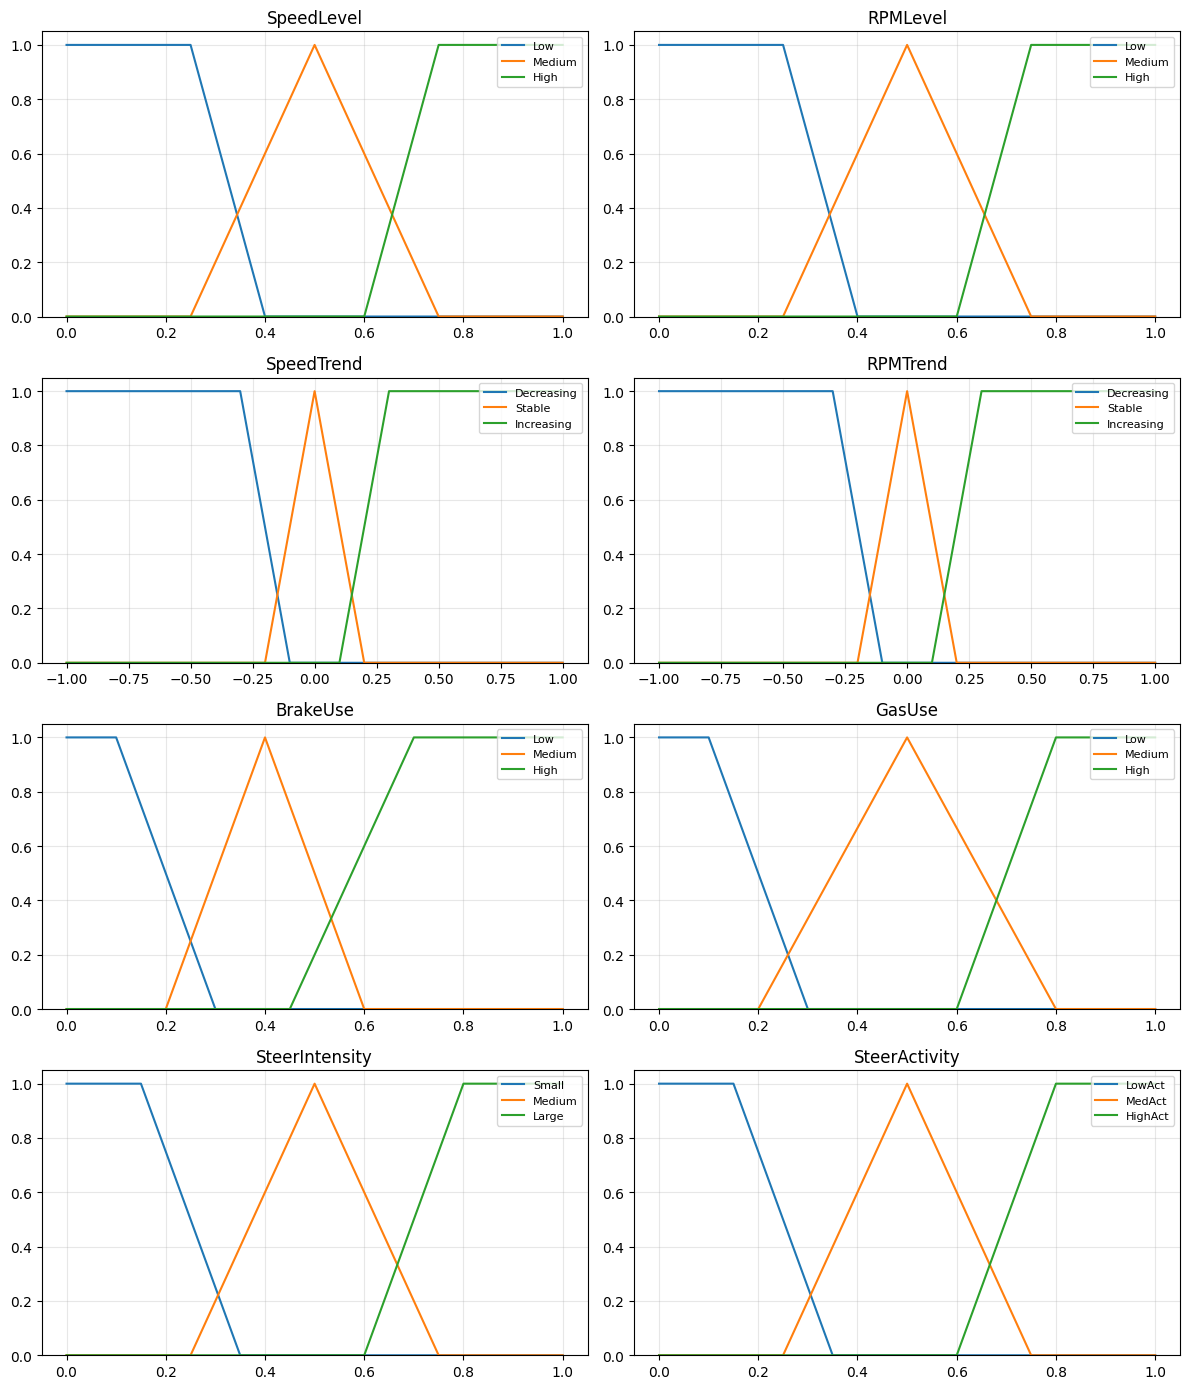

In [23]:
plots = [
    ("SpeedLevel", level_u, speed_level_mf),
    ("RPMLevel", level_u, rpm_level_mf),
    ("SpeedTrend", trend_u, speed_trend_mf),
    ("RPMTrend", trend_u, rpm_trend_mf),
    ("BrakeUse", level_u, brake_use_mf),
    ("GasUse", level_u, gas_use_mf),
    ("SteerIntensity", level_u, steer_intensity_mf),
    ("SteerActivity", level_u, steer_activity_mf),
]

fig, axes = plt.subplots(4, 2, figsize=(12, 14), sharex=False)
axes = axes.flatten()

for ax, (title, universe, mf_dict) in zip(axes, plots):
    for label, mf in mf_dict.items():
        ax.plot(universe, mf, label=label)
    ax.set_title(title)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", fontsize=8)

# Hide any unused axes if the grid is bigger than plots
for ax in axes[len(plots):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [30]:
# ============================================================
# Sugeno-style scoring system (3 outputs in [0,1]):
#   mu_stopping, mu_overtaking, mu_turnings
# ============================================================

# --- Helpers -------------------------------------------------

def mf_degree(x, universe, mf):
    """Degree of membership for crisp x given a discrete MF defined on universe."""
    return float(fuzz.interp_membership(universe, mf, x))

def AND(*vals):
    """t-norm (min)."""
    return float(np.min(vals))

def OR(*vals):
    """s-norm (max)."""
    return float(np.max(vals))

def NOT(val):
    """Standard negation."""
    return float(1.0 - val)

def sugeno_output(rule_strengths, rule_outputs, default=0.0):
    """
    Sugeno weighted average.
    rule_strengths: list of firing strengths w_i in [0,1]
    rule_outputs:   list of constants z_i in [0,1]
    """
    w = np.asarray(rule_strengths, dtype=float)
    z = np.asarray(rule_outputs, dtype=float)
    denom = w.sum()
    if denom <= 1e-12:
        return float(default)
    return float((w * z).sum() / denom)

# --- Rule evaluation -----------------------------------------
def evaluate_sugeno_scores(
    speed_level,      # [0,1]
    speed_trend,      # [-1,1]
    brake_use,        # [0,1]
    gas_use,          # [0,1]
    steer_intensity,  # [0,1]  (abs steering feature)
    steer_activity,   # [0,1]
    gear_change=0.0   # {0,1} or [0,1]
):
    # ---- Fuzzify inputs (degrees) ---------------------------
    # Speed level
    spL = mf_degree(speed_level, level_u, speed_level_mf["Low"])
    spM = mf_degree(speed_level, level_u, speed_level_mf["Medium"])
    spH = mf_degree(speed_level, level_u, speed_level_mf["High"])

    # Speed trend
    trD = mf_degree(speed_trend, trend_u, speed_trend_mf["Decreasing"])
    trS = mf_degree(speed_trend, trend_u, speed_trend_mf["Stable"])
    trI = mf_degree(speed_trend, trend_u, speed_trend_mf["Increasing"])

    # Brake / gas use
    brL = mf_degree(brake_use, level_u, brake_use_mf["Low"])
    brM = mf_degree(brake_use, level_u, brake_use_mf["Medium"])
    brH = mf_degree(brake_use, level_u, brake_use_mf["High"])

    gaL = mf_degree(gas_use, level_u, gas_use_mf["Low"])
    gaM = mf_degree(gas_use, level_u, gas_use_mf["Medium"])
    gaH = mf_degree(gas_use, level_u, gas_use_mf["High"])

    # Steering
    stS = mf_degree(steer_intensity, level_u, steer_intensity_mf["Small"])
    stM = mf_degree(steer_intensity, level_u, steer_intensity_mf["Medium"])
    stL = mf_degree(steer_intensity, level_u, steer_intensity_mf["Large"])

    actL = mf_degree(steer_activity, level_u, steer_activity_mf["LowAct"])
    actM = mf_degree(steer_activity, level_u, steer_activity_mf["MedAct"])
    actH = mf_degree(steer_activity, level_u, steer_activity_mf["HighAct"])

    # Gear change as fuzzy degree (0..1)
    gc = float(np.clip(gear_change, 0.0, 1.0))
    ngc = 1.0 - gc

    # ============================================================
    # STOPPING (Braking) rules (output constants in [0,1])
    # Intuition: brake use high + (speed decreasing OR at least not increasing),
    #           gas low supports. Avoid using SpeedLevel Low as a main trigger.
    # ============================================================
    stop_w = []
    stop_z = []
    
    stop_w.append(brH)
    stop_z.append(0.95)
    
    # S1: IF brake is High AND speed trend is Decreasing THEN stopping(braking) is 1.0
    stop_w.append(AND(brH, trD))
    stop_z.append(0.9)

    # S2: IF brake is High AND speed trend is Stable THEN stopping(braking) is 0.7
    stop_w.append(AND(brH, trS))
    stop_z.append(0.7)

    # S3: IF brake is Medium AND speed trend is Decreasing THEN stopping(braking) is 0.7
    stop_w.append(AND(brM, trD))
    stop_z.append(0.7)

    # S4: IF brake is High AND gas is Low THEN stopping(braking) is 0.8
    # (captures clear braking even if trend is noisy inside the window)
    stop_w.append(AND(brH, gaL))
    stop_z.append(0.8)

    # S5: IF brake is Medium AND gas is Low AND speed trend is Decreasing THEN stopping is 0.6
    stop_w.append(AND(brM, gaL, trD))
    stop_z.append(0.6)
    
    #S6: IF speed is descending AND RPMTrend is Decreasing THEN stopping is 0.8
    stop_w.append(AND(trD, trD))
    stop_z.append(0.8)

    # --- Inhibitors (situations that contradict braking) ----------
    # S6: IF brake is Low THEN stopping(braking) is 0.0
    #stop_w.append(brL)
    #stop_z.append(0.0)

    # S7: IF speed trend is Increasing AND gas is Medium/High THEN stopping(braking) is 0.0
    #stop_w.append(AND(trI, OR(gaM, gaH)))
    #stop_z.append(0.0)

    # S8: IF gas is High AND brake is Low THEN stopping(braking) is 0.0
    #stop_w.append(AND(gaH, brL))
    #stop_z.append(0.0)

    mu_stopping = sugeno_output(stop_w, stop_z, default=0.0)

    # ============================================================
    # OVERTAKING rules
    # Intuition: speed increasing + gas high + brake low,
    #            steering activity medium but steering intensity not large.
    # ============================================================
    over_w = []
    over_z = []

    # O1: IF trend Increasing AND gas High AND brake Low THEN overtaking is 1.0
    over_w.append(AND(trI, gaH, brL))
    over_z.append(1.0)

    # O2: IF speed Medium/High AND gas Medium/High AND brake Low THEN overtaking is 0.8
    over_w.append(AND(OR(spM, spH), OR(gaM, gaH), brL))
    over_z.append(0.8)

    # O3: IF steer activity MedAct AND steer intensity Small/Medium AND trend Increasing THEN overtaking is 0.8
    over_w.append(AND(actM, OR(stS, stM), trI))
    over_z.append(0.8)

    # O4: IF gear change is present AND gas Medium/High AND trend Increasing THEN overtaking is 0.7
    over_w.append(AND(gc, OR(gaM, gaH), trI))
    over_z.append(0.7)

    # O5 (inhibitor): IF steer intensity Large THEN overtaking is 0.0
    #over_w.append(stL)
    #over_z.append(0.0)

    # O6 (inhibitor): IF brake High THEN overtaking is 0.0
    #over_w.append(brH)
    #over_z.append(0.0)

    mu_overtaking = sugeno_output(over_w, over_z, default=0.0)

    # ============================================================
    # TURNINGS rules
    # Intuition: steering intensity large + speed low/medium; steering activity high supports.
    # ============================================================
    turn_w = []
    turn_z = []

    # T1: IF steer intensity Large AND speed Low/Medium THEN turnings is 1.0
    turn_w.append(AND(stL, OR(spL, spM)))
    turn_z.append(1.0)

    # T2: IF steer intensity Large AND steer activity HighAct THEN turnings is 1.0
    turn_w.append(AND(stL, actH))
    turn_z.append(1.0)

    # T3: IF steer intensity Medium AND speed Low AND brake Medium THEN turnings is 0.7
    turn_w.append(AND(stM, spL, brM))
    turn_z.append(0.7)

    # T4: IF steer activity MedAct/HighAct AND speed Low/Medium THEN turnings is 0.7
    turn_w.append(AND(OR(actM, actH), OR(spL, spM)))
    turn_z.append(0.7)
    
    turn_w.append(AND(OR(gaM, gaH), brL))
    turn_z.append(0.8)

    # T5 (inhibitor): IF speed High AND steer intensity Small THEN turnings is 0.0
    #turn_w.append(AND(spH, stS))
    #turn_z.append(0.0)

    # T6 (inhibitor): IF trend Increasing AND gas High AND steer intensity Small THEN turnings is 0.0
    #turn_w.append(AND(trI, gaH, stS))
    #turn_z.append(0.0)

    mu_turnings = sugeno_output(turn_w, turn_z, default=0.0)

    return mu_stopping, mu_overtaking, mu_turnings


In [31]:
required_cols = [
    "SpeedLevel", "SpeedTrend", "BrakeUse", "GasUse",
    "SteerIntensity", "SteerActivity", "GearChange"
]

# ---------- 1) Idle detection (row = window-feature row) ----------
IDLE_SPEED_MAX = 0.05
IDLE_BRAKE_MAX = 0.10
IDLE_GAS_MAX   = 0.10
IDLE_STEERACT_MAX = 0.10
IDLE_TREND_ABS_MAX = 0.10  # near-stable speed

idle_mask = (
    (df["SpeedLevel"] <= IDLE_SPEED_MAX) &
    (df["BrakeUse"]   <= IDLE_BRAKE_MAX) &
    (df["GasUse"]     <= IDLE_GAS_MAX) &
    (df["SteerActivity"] <= IDLE_STEERACT_MAX) &
    (df["SpeedTrend"].abs() <= IDLE_TREND_ABS_MAX)
)

# ---------- 2) Prepare output scores (aligned) ----------
mu_vals = pd.DataFrame(
    0.0,
    index=df.index,
    columns=["mu_stopping", "mu_overtaking", "mu_turnings"]
)

# ---------- 3) Compute only for NON-idle rows ----------
non_idle_idx = df.index[~idle_mask]

inputs_non_idle = df.loc[non_idle_idx, required_cols]

mu_non_idle = inputs_non_idle.apply(
    lambda r: evaluate_sugeno_scores(
        speed_level=float(r["SpeedLevel"]),
        speed_trend=float(r["SpeedTrend"]),
        brake_use=float(r["BrakeUse"]),
        gas_use=float(r["GasUse"]),
        steer_intensity=float(r["SteerIntensity"]),
        steer_activity=float(r["SteerActivity"]),
        gear_change=float(r["GearChange"]),
    ),
    axis=1,
    result_type="expand"
)

mu_non_idle.columns = ["mu_stopping", "mu_overtaking", "mu_turnings"]
mu_non_idle.index = non_idle_idx  # safeguard

# Fill only non-idle rows
mu_vals.loc[non_idle_idx, :] = mu_non_idle

# ---------- 4) Join back to original df (aligned) ----------
df_with_scores = df.copy()
df_with_scores["is_idle"] = idle_mask.astype(bool)
df_with_scores = df_with_scores.join(mu_vals)

df_with_scores.head()

,driver,maneuver,window_start,window_end,SpeedLevel,SpeedTrend,BrakeUse,GasUse,SteerIntensity,SteerActivity,GearChange,RPMTrend,RPMLevel,Maneuver marker flag,is_idle,mu_stopping,mu_overtaking,mu_turnings
0,Driver1,Overtaking,34.419,35.396,0.652298,-0.029335,0.0,0.113034,0.166667,0.009585,0,0.160012,0.512208,0.25,False,0.0,0.0,0.000000
1,Driver1,Overtaking,34.931,35.908,0.641874,-0.008913,0.0,0.300594,0.000000,0.000000,0,0.507368,0.715344,0.75,False,0.0,0.8,0.800000
2,Driver1,Overtaking,35.448,36.419,0.641136,0.006324,0.0,0.444917,0.000000,0.000000,0,0.224025,0.891715,1.00,False,0.0,0.8,0.800000
3,Driver1,Overtaking,35.959,36.930,0.651704,0.032928,0.0,0.594665,0.333333,0.027942,0,-0.289368,0.795036,1.00,False,0.0,0.8,0.800000
4,Driver1,Overtaking,36.470,37.438,0.672172,0.044815,0.0,0.721054,0.915858,0.045842,0,0.073011,0.755829,1.00,False,0.0,0.8,0.867929


In [32]:
# --- Map maneuver -> corresponding mu column ---
mu_map = {
    "Stopping": "mu_stopping",
    "Overtaking": "mu_overtaking",
    "Turnings": "mu_turnings",
}

flag_col = "Maneuver marker flag"
idle_col = "is_idle"   # adjust if your column name differs
FLAG_BIN_THR = 0.7  # umbral para binarizar la etiqueta fuzzy si se usan metricas de clasificacion

# --- Sanity checks ---
if flag_col not in df_with_scores.columns:
    raise ValueError(f"Missing '{flag_col}' column in df_with_scores")

if idle_col not in df_with_scores.columns:
    raise ValueError(f"Missing '{idle_col}' column in df_with_scores (idle flag)")

missing_mu = [c for c in mu_map.values() if c not in df_with_scores.columns]
if missing_mu:
    raise ValueError(f"Missing mu columns in df_with_scores: {missing_mu}")

if "maneuver" not in df_with_scores.columns:
    raise ValueError("Missing 'maneuver' column in df_with_scores")

# --- Enforce numeric types ---
df_with_scores = df_with_scores.copy()
df_with_scores[flag_col] = pd.to_numeric(df_with_scores[flag_col], errors="coerce").fillna(0.0)
df_with_scores[idle_col] = df_with_scores[idle_col].astype(bool)
for c in mu_map.values():
    df_with_scores[c] = pd.to_numeric(df_with_scores[c], errors="coerce").fillna(0.0)

rows = []

for man, mu_col in mu_map.items():
    # --- Filter: only rows of this maneuver AND non-idle ---
    df_eval = df_with_scores[(df_with_scores["maneuver"] == man) & (~df_with_scores[idle_col])].copy()

    if df_eval.empty:
        rows.append({
            "maneuver": man,
            "mu_col": mu_col,
            "n_rows": 0,
            "n_pos_flag": 0,
            "MSE(mu-flag)": np.nan,
            "RMSE": np.nan,
            "MAE": np.nan,
            "Brier": np.nan,
            "ROC_AUC": np.nan,
            "PR_AUC": np.nan,
            "best_thr_F1": np.nan,
            "F1@thr": np.nan,
            "Precision@thr": np.nan,
            "Recall@thr": np.nan,
            "TP": np.nan, "FP": np.nan, "TN": np.nan, "FN": np.nan
        })
        continue

    y_true = df_eval[flag_col].values.astype(float)
    y_score = df_eval[mu_col].values.astype(float)

    # --- Errors (fuzzy target) ---
    mse = mean_squared_error(y_true, y_score)
    mae = mean_absolute_error(y_true, y_score)
    rmse = np.sqrt(mse)

    # --- Binariza etiqueta fuzzy para metricas de clasificacion ---
    y_true_bin = (y_true >= FLAG_BIN_THR).astype(int)
    n_pos = int(y_true_bin.sum())

    # Brier requiere etiqueta binaria
    brier = brier_score_loss(y_true_bin, y_score)

    # AUC metrics only if both classes present
    has_both = (np.unique(y_true_bin).size == 2)
    roc_auc = roc_auc_score(y_true_bin, y_score) if has_both else np.nan
    pr_auc  = average_precision_score(y_true_bin, y_score) if has_both else np.nan

    # --- Fixed threshold at 0.5 ---
    thr = 0.5
    y_pred = (y_score >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true_bin, y_pred, average="binary", zero_division=0
    )

    cm = confusion_matrix(y_true_bin, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    rows.append({
        "maneuver": man,
        "mu_col": mu_col,
        "n_rows": int(len(df_eval)),
        "n_pos_flag": n_pos,
        "MSE(mu-flag)": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Brier": brier,
        "ROC_AUC": roc_auc,
        "PR_AUC": pr_auc,
        "best_thr_F1": thr,
        "F1@thr": float(f1),
        "Precision@thr": float(p),
        "Recall@thr": float(r),
        "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn)
    })

results = pd.DataFrame(rows).sort_values("maneuver")
results


,maneuver,mu_col,n_rows,n_pos_flag,MSE(mu-flag),RMSE,MAE,Brier,ROC_AUC,PR_AUC,best_thr_F1,F1@thr,Precision@thr,Recall@thr,TP,FP,TN,FN
1,Overtaking,mu_overtaking,1491,1375,0.171853,0.414552,0.312151,0.197705,0.561721,0.934054,0.5,0.894180,0.930763,0.860364,1183,88,28,192
0,Stopping,mu_stopping,1665,1480,0.465957,0.682610,0.550827,0.487124,0.552820,0.909498,0.5,0.647389,0.896057,0.506757,750,87,98,730
2,Turnings,mu_turnings,2165,1948,0.232373,0.482051,0.303491,0.256677,0.726220,0.953227,0.5,0.839126,0.924074,0.768480,1497,123,94,451
